In [9]:
import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch 
import requests
import matplotlib 
from PIL import Image
from torchvision import models, transforms
from torch.nn import functional as F
from torchvision.transforms import ToTensor, Resize, Compose, ToPILImage
from visualisation.core import *
from visualisation.core.utils import device
from visualisation.core.utils import image_net_preprocessing
from visualisation.core.utils import image_net_postprocessing

(-0.5, 752.5, 634.5, -0.5)

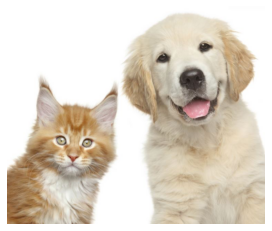

In [10]:
# The glob module finds all the pathnames matching a specified input image
image_paths = glob.glob('./input_images/*.*')
# Open and save the input images in a list
images = list(map(lambda x: Image.open(x), image_paths))

# Take an example, plot the last image in the list
plt.imshow(images[5])
plt.axis('off')

In [11]:
# resize all the input images
# Compose: chain the resize and normalize operations together to achieve a transformation pipeline
# unsqueeze(0): Returns a new tensor with a dimension of size one inserted at the fist axis for batch
inputs  = [Compose([Resize((224,224)), ToTensor(), image_net_preprocessing])(x).unsqueeze(0) for x in images]
# Send the inputs data to device. Here the device will be GPU if it is available, otherwise CPU will be selected
inputs = [i.to(device) for i in inputs]

In [12]:
# load the labels of the Imagnenet dataset
LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
# download the imagenet category list
classes = {int(key):value for (key, value)
          in requests.get(LABELS_URL).json().items()}

In [13]:
# convert tensor to image
def tensor2img(tensor, ax=plt):
    # squeeze(): Remove the first axes
    tensor = tensor.squeeze()
    # permute(): change the order of the channel from (c,h,w) to (h,w,c)
    if len(tensor.shape) > 2: tensor = tensor.permute(1, 2, 0)
    # detach() creates a tensor that shares storage with tensor that does not require grad
    # cpu(): move the tensor to cpu() because some operations on tensors cannot be performed on cuda(GPU)
    # numpy(): convert the tensor to numpy array
    img = tensor.detach().cpu().numpy()
    return img

In [14]:
# Define a masking function to mask the unimportant regions in heatmap and overlay it with the original image
def masking(cam, input_img, threshold):
    # cam: the original heatmap
    # threshold: a threshold for masking. If the value of a pixel is smaller than this threshold, this pixel will be masked.
    # Change cam to numpy array
    cam = cam.numpy()
    # Limit its range to 0-1
    cam -= np.min(cam)
    cam /= np.max(cam) 
    # Resize it to match the size of the input image
    cam = cv2.resize(cam, (224,224))
    # Define the mask. The pixel can be selected only its value is greater than the threshold
    mask = cam > threshold
    # Change the postprocessed input image from tensor to image
    # squeeze(): Remove the first axes
    input_img = tensor2img(image_net_postprocessing(input_img[0].squeeze()))
    # Get a copy of the input image
    copy = input_img.copy()
    # Set the pixels values in copy array to 0 at the positions where the values in the mask array are 0
    copy[mask == 0] = 0
    # Overlaying
    mask = 0.7 * copy + 0.3 * input_img
    
    return mask

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The Grad-CAM Heatmap for class: golden retriever is generated as following.


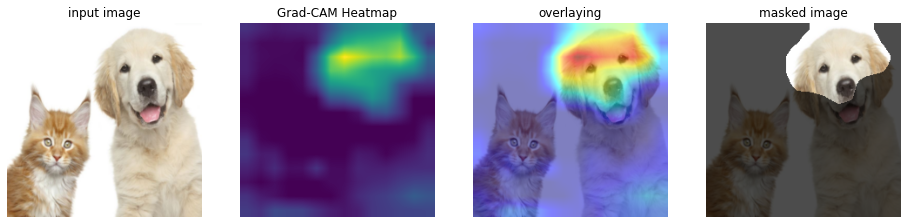

In [15]:
# Pick a input image.
input_image = inputs[5]
# Select a CNN model and send it to device.
model = models.vgg19(pretrained=True).to(device)
model.eval()
# Forward pass. 
predictions = model(input_image)
# Select the class with the maximum prediction value as the target class 
_, Top_One_pred = torch.max(predictions, dim=1)
# Convert Pytorch variable to numpy array
# [0] to get rid of the first channel
# cpu(): move the tensor to cpu() because some operations on tensors cannot be performed on cuda(GPU)
Top_One_pred = Top_One_pred.cpu().numpy()[0]
# For a particular class of interest, set its index in the ImageNet dataset as the target_class.Range: 0-999.
# For example:
# Top_One_pred = 452 


# Grad-CAM result
grad_cam = GradCam(model, device)

heatmap_with_image = grad_cam(input_image, target_class = Top_One_pred,
          postprocessing=image_net_postprocessing)


print('The Grad-CAM Heatmap for class: {} is generated as following.'.format(classes[Top_One_pred]))

# set the threshold to mask the heatmap. 0.4 for float data type
threshold =  0.4
# masking function. cpu(): move the tensor to cpu() because some operations on tensors cannot be performed on cuda(GPU)
# grad_cam.cam: the heatmap without overlaying with the input image
mask = masking(grad_cam.cam.cpu(), input_image.cpu(), threshold)



# Plot
fig = plt.figure(figsize=(16, 4))
# Plot the input image
ax = fig.add_subplot(1, 4, 1)
# Convert the tensor to image. squeeze(): Remove the first axes
imgplot = plt.imshow(tensor2img(image_net_postprocessing(input_image.squeeze())))
plt.axis('off')
ax.set_title('input image')
# Plot the CAM Heatmap
ax = fig.add_subplot(1, 4, 2)
# transform the tensor to numpy array. 
cam = grad_cam.cam.cpu().numpy()
cam = cv2.resize(cam, (224,224))
imgplot = plt.imshow(cam)
plt.savefig('C:/Users/Yutong Yang/Desktop/3_vgg_guidedgrad.jpg')
plt.axis('off')
ax.set_title('Grad-CAM Heatmap')
# Plot the overlaying result
ax = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(tensor2img(heatmap_with_image[0]))
plt.axis('off')
ax.set_title('overlaying')
ax = fig.add_subplot(1, 4, 4)
# Plot the masked original image according to the heatmap
imgplot = plt.imshow(mask)
plt.axis('off')
ax.set_title('masked image')

torch.cuda.empty_cache()



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The Grad-CAM Heatmap for class: tiger cat is generated as following.


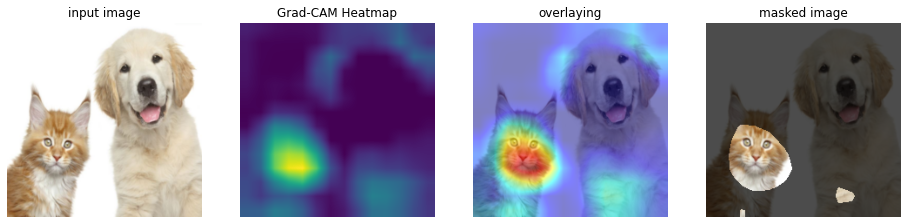

In [16]:
# Change the target class by set "class_of_interest = id",id is the id of the targets in the Imagenet dataset and it belongs to 0-999
class_of_interest = 282
new_heatmap_with_image = grad_cam(input_image, target_class = class_of_interest,
          postprocessing=image_net_postprocessing)

print('The Grad-CAM Heatmap for class: {} is generated as following.'.format(classes[class_of_interest]))

# set the threshold to crop the heatmap and polt it
threshold =  0.4
# masking function
mask_new = masking(grad_cam.cam.cpu(), input_image.cpu(), threshold)

# Plot
fig = plt.figure(figsize=(16, 4))
# Plot the input image
ax = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(tensor2img(image_net_postprocessing(input_image.squeeze())))
plt.axis('off')
ax.set_title('input image')
# Plot the CAM Heatmap
ax = fig.add_subplot(1, 4, 2)
cam = grad_cam.cam.cpu().numpy()
cam = cv2.resize(cam, (224,224))
imgplot = plt.imshow(cam)
plt.axis('off')
ax.set_title('Grad-CAM Heatmap')
# Plot the overlaying
ax = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(tensor2img(new_heatmap_with_image[0]))
plt.axis('off')
ax.set_title('overlaying')
# Plot the masked original image according to the heatmap
ax = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(mask_new)
plt.axis('off')
ax.set_title('masked image')

torch.cuda.empty_cache()